In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
sheet = pd.read_excel('data_input/山东丙烯主流价_SC指数拟合残差_原油指数.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['山东丙烯主流价-SC指数拟合残差/结算价:原油指数'].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=21, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()

,山东丙烯主流价-SC指数拟合残差/结算价:原油指数,丙烯/期末库存/中国（周）超季节性/3年,山东汽柴油加权裂解价差,丙烯上游-下游开工/不含PP/LZ同差,石脑油价格（CFR日本）-Brent原油期货价格,LME铜价,PP-SC（期货指数）拟合残差/结算价:原油指数,丙烯：现货外销量：华东地区（除山东）（周）超季节性/3年,丙烯现货外销量（除山东）超季节性/3年,秦皇岛动力煤价格Q5500,新增社融滚动12个月累计同比,LME铜价同比,螺纹期货价格
2025-11-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
sheet1 = pd.ExcelFile('eta/山东柴油裂解差(多因子)_合并数据.xlsx').parse('Sheet1')
sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
sheet1 = sheet1.sort_values('Date', ascending=True)
sheet1 = sheet1.drop(columns=['真实值'])
sheet1 = sheet1.dropna()
sheet1.head()

,Date,预测值
19,2025-11-03,269.0
18,2025-11-04,263.3
17,2025-11-05,280.7
16,2025-11-06,309.3
15,2025-11-07,298.7


In [6]:
sheet2 = pd.ExcelFile('eta/汽油裂解差(多因子)_合并数据.xlsx').parse('Sheet1')
sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')
sheet2 = sheet2.sort_values('Date', ascending=True)
sheet2 = sheet2.drop(columns=['真实值'])
sheet2 = sheet2.dropna()
sheet2.head()

,Date,预测值
19,2025-10-31,385.4
18,2025-11-03,443.1
17,2025-11-04,644.0
16,2025-11-05,599.8
15,2025-11-06,482.7


In [7]:
sheet1['山东汽柴油加权裂解价'] = (sheet2['预测值'] + 2*sheet1['预测值']) / 3
sheet1.head()

,Date,预测值,山东汽柴油加权裂解价
19,2025-11-03,269.0,307.800000
18,2025-11-04,263.3,323.233333
17,2025-11-05,280.7,401.800000
16,2025-11-06,309.3,406.133333
15,2025-11-07,298.7,360.033333


In [8]:
sheet3 = pd.ExcelFile('eta/石脑油-Brent_合并数据.xlsx').parse('Sheet1')
sheet3['Date'] = pd.to_datetime(sheet3['Date'], errors='coerce')
sheet3 = sheet3.sort_values('Date', ascending=True)
sheet3 = sheet3.drop(columns=['石脑油价格（CFR日本）-Brent原油期货价格'])
sheet3 = sheet3.dropna()
sheet3.head()


,Date,石脑油价格（CFR日本）-Brent原油期货价格_预测
20,2025-10-31,95.715479
19,2025-11-03,84.125468
18,2025-11-04,86.102522
17,2025-11-05,88.394171
16,2025-11-06,86.611464


In [9]:
sheet4 = pd.ExcelFile('eta/PE-SC拟合残差_SC_合并数据.xlsx').parse('Sheet1')
sheet4['Date'] = pd.to_datetime(sheet4['Date'], errors='coerce')
sheet4 = sheet4.sort_values('Date', ascending=True)
sheet4 = sheet4.drop(columns=['真实值'])
sheet4 = sheet4.dropna()
sheet4.head()


,Date,预测值
21,2025-11-03,-665.7
20,2025-11-04,-665.3
19,2025-11-05,-579.4
18,2025-11-06,-851.8
17,2025-11-07,-848.5


In [10]:
# 尝试多个可能的文件路径
file_paths5 = [
    os.path.expanduser("~/Desktop/X-BASE/动力煤/eta/秦皇岛动力煤价格_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/动力煤/eta/秦皇岛动力煤价格_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/动力煤/eta/秦皇岛动力煤价格_合并数据.xlsx")
]

file_path5 = None
for path5 in file_paths5:
    if os.path.isfile(path5):  # 确保是文件而不是目录
        file_path5 = path5
        break

if file_path5 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet5 = pd.read_excel(file_path5, sheet_name='Sheet1')
    sheet5['Date'] = pd.to_datetime(sheet5['Date'], errors='coerce')
    sheet5 = sheet5.drop(columns=['真实值'])
    sheet5 = sheet5.dropna()
    sheet5 = sheet5.sort_values('Date', ascending=True)
    
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet5.head()

,Date,预测值
24,2025-11-03,779.8
23,2025-11-04,775.3
22,2025-11-05,771.6
21,2025-11-06,767.0
20,2025-11-07,767.9


In [11]:
# 尝试多个可能的文件路径
file_paths6 = [
    os.path.expanduser("~/Desktop/X-BASE/铜/eta/LME铜价_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/铜/eta/LME铜价_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/铜/eta/LME铜价_合并数据.xlsx")
]

file_path6 = None
for path6 in file_paths6:
    if os.path.isfile(path6):  # 确保是文件而不是目录
        file_path6 = path6
        break

if file_path6 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet6 = pd.read_excel(file_path6, sheet_name='Sheet1')
    sheet6['Date'] = pd.to_datetime(sheet6['Date'], errors='coerce')
    sheet6 = sheet6.drop(columns=['真实值'])
    sheet6 = sheet6.dropna()
    sheet6 = sheet6.sort_values('Date', ascending=True)
    
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet6.head()

,Date,预测值
20,2025-11-03,10914.4
19,2025-11-04,10961.7
18,2025-11-05,10958.2
17,2025-11-06,10954.0
16,2025-11-07,10954.8


In [12]:
# 尝试多个可能的文件路径
file_paths7 = [
    os.path.expanduser("~/Desktop/X-BASE/螺纹/eta/螺纹期货价格_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/螺纹/eta/螺纹期货价格_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/螺纹/eta/螺纹期货价格_合并数据.xlsx")
]

file_path7 = None
for path7 in file_paths7:
    if os.path.isfile(path7):  # 确保是文件而不是目录
        file_path7 = path7
        break

if file_path7 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet7 = pd.read_excel(file_path7, sheet_name='Sheet1')
    sheet7['Date'] = pd.to_datetime(sheet7['Date'], errors='coerce')
    sheet7 = sheet7.drop(columns=['螺纹期货价格'])
    sheet7 = sheet7.dropna()
    sheet7 = sheet7.sort_values('Date', ascending=True)
    
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet7.head()

,Date,螺纹期货价格_预测
19,2025-11-03,3236.474561
18,2025-11-04,3282.692914
17,2025-11-05,3327.514787
16,2025-11-06,3386.323930
15,2025-11-07,3440.362514


In [13]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', '山东汽柴油加权裂解价']],
    on='Date',
    how='left'
)
sheet_daily['山东汽柴油加权裂解价差'] = sheet_daily['山东汽柴油加权裂解价差'].fillna(sheet_daily['山东汽柴油加权裂解价'])
sheet_daily = sheet_daily.drop(columns=['山东汽柴油加权裂解价'])

# 合并 sheet2 的美元指数数据 
sheet_daily = pd.merge(
    sheet_daily,
    sheet3[['Date', '石脑油价格（CFR日本）-Brent原油期货价格_预测']],
    on='Date',
    how='left'
)
sheet_daily['石脑油价格（CFR日本）-Brent原油期货价格'] = sheet_daily['石脑油价格（CFR日本）-Brent原油期货价格'].fillna(sheet_daily['石脑油价格（CFR日本）-Brent原油期货价格_预测'])
sheet_daily = sheet_daily.drop(columns=['石脑油价格（CFR日本）-Brent原油期货价格_预测'])

# 合并 sheet2 的美元指数数据 
sheet_daily = pd.merge(
    sheet_daily,
    sheet4[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['PP-SC（期货指数）拟合残差/结算价:原油指数'] = sheet_daily['PP-SC（期货指数）拟合残差/结算价:原油指数'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

# 合并 sheet2 的美元指数数据 
sheet_daily = pd.merge(
    sheet_daily,
    sheet5[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['秦皇岛动力煤价格Q5500'] = sheet_daily['秦皇岛动力煤价格Q5500'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])


# 合并 sheet2 的美元指数数据 
sheet_daily = pd.merge(
    sheet_daily,
    sheet6[['Date', '预测值']].assign(预测值=lambda x: x['预测值'].pct_change(periods=252)*100),
    on='Date',
    how='left'
)
sheet_daily['LME铜价'] = sheet_daily['LME铜价'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])


# 合并 sheet2 的美元指数数据 
sheet_daily = pd.merge(
    sheet_daily,
    sheet7[['Date', '螺纹期货价格_预测']],
    on='Date',
    how='left'
)
sheet_daily['螺纹期货价格'] = sheet_daily['螺纹期货价格'].fillna(sheet_daily['螺纹期货价格_预测'])
sheet_daily = sheet_daily.drop(columns=['螺纹期货价格_预测'])

# 将 sheet_daily 重新赋值给 sheet
sheet = sheet_daily.copy()
sheet = sheet.set_index('Date')

In [14]:
sheet.columns

Index(['山东丙烯主流价-SC指数拟合残差/结算价:原油指数', '丙烯/期末库存/中国（周）超季节性/3年', '山东汽柴油加权裂解价差',
       '丙烯上游-下游开工/不含PP/LZ同差', '石脑油价格（CFR日本）-Brent原油期货价格', 'LME铜价',
       'PP-SC（期货指数）拟合残差/结算价:原油指数', '丙烯：现货外销量：华东地区（除山东）（周）超季节性/3年',
       '丙烯现货外销量（除山东）超季节性/3年', '秦皇岛动力煤价格Q5500', '新增社融滚动12个月累计同比', 'LME铜价同比',
       '螺纹期货价格'],
      dtype='object')

In [15]:
################################# 处理缺失值 #################################
fill_methods = {
'丙烯/期末库存/中国（周）超季节性/3年': 'interpolate', 
'山东汽柴油加权裂解价差': 'interpolate',
'丙烯上游-下游开工/不含PP/LZ同差': 'interpolate', 
'石脑油价格（CFR日本）-Brent原油期货价格': 'interpolate',
'PP-SC（期货指数）拟合残差/结算价:原油指数': 'interpolate'  , 
'丙烯：现货外销量：华东地区（除山东）（周）超季节性/3年': 'interpolate',
'丙烯现货外销量（除山东）超季节性/3年': 'interpolate', 
'秦皇岛动力煤价格Q5500': 'interpolate', 
'新增社融滚动12个月累计同比': 'interpolate', 
'LME铜价同比': 'interpolate',
'螺纹期货价格': 'interpolate',
'LME铜价': 'interpolate',
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
#sheet.loc[:last_day, 'LME铜价'] = sheet.loc[:last_day, 'LME铜价'].interpolate(method='linear')

#################################  因子处理  #################################

sheet['丙烯/期末库存/中国（周）超季节性/3年_提前21天'] = sheet['丙烯/期末库存/中国（周）超季节性/3年'].shift(21)
sheet['山东汽柴油加权裂解价差_提前10天'] = sheet['山东汽柴油加权裂解价差'].shift(10)
sheet['丙烯上游-下游开工/不含PP/LZ同差_提前10天'] = sheet['丙烯上游-下游开工/不含PP/LZ同差'].shift(10)
sheet['丙烯：现货外销量：华东地区（除山东）（周）超季节性/3年_提前15天'] = sheet['丙烯：现货外销量：华东地区（除山东）（周）超季节性/3年'].shift(15)
sheet['丙烯现货外销量（除山东）超季节性/3年_提前35天'] = sheet['丙烯现货外销量（除山东）超季节性/3年'].shift(35)
sheet['新增社融滚动12个月累计同比_提前242天'] = sheet['新增社融滚动12个月累计同比'].shift(242)
sheet['LME铜价同比_提前20天'] = sheet['LME铜价同比'].shift(20)


sheet['丙烯/期末库存/中国（周）超季节性/3年_提前21天_逆序'] = reverse_column(sheet, '丙烯/期末库存/中国（周）超季节性/3年_提前21天')
sheet['山东汽柴油加权裂解价差_提前10天_逆序'] = reverse_column(sheet, '山东汽柴油加权裂解价差_提前10天')
sheet['丙烯上游-下游开工/不含PP/LZ同差_提前10天_逆序'] = reverse_column(sheet, '丙烯上游-下游开工/不含PP/LZ同差_提前10天')
sheet['丙烯：现货外销量：华东地区（除山东）（周）超季节性/3年_提前15天_逆序'] = reverse_column(sheet, '丙烯：现货外销量：华东地区（除山东）（周）超季节性/3年_提前15天')
sheet['丙烯现货外销量（除山东）超季节性/3年_提前35天_逆序'] = reverse_column(sheet, '丙烯现货外销量（除山东）超季节性/3年_提前35天')


################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-01-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['山东丙烯主流价-SC指数拟合残差/结算价:原油指数'].notna())
]

################################# 数据 读取-处理 结束 #################################

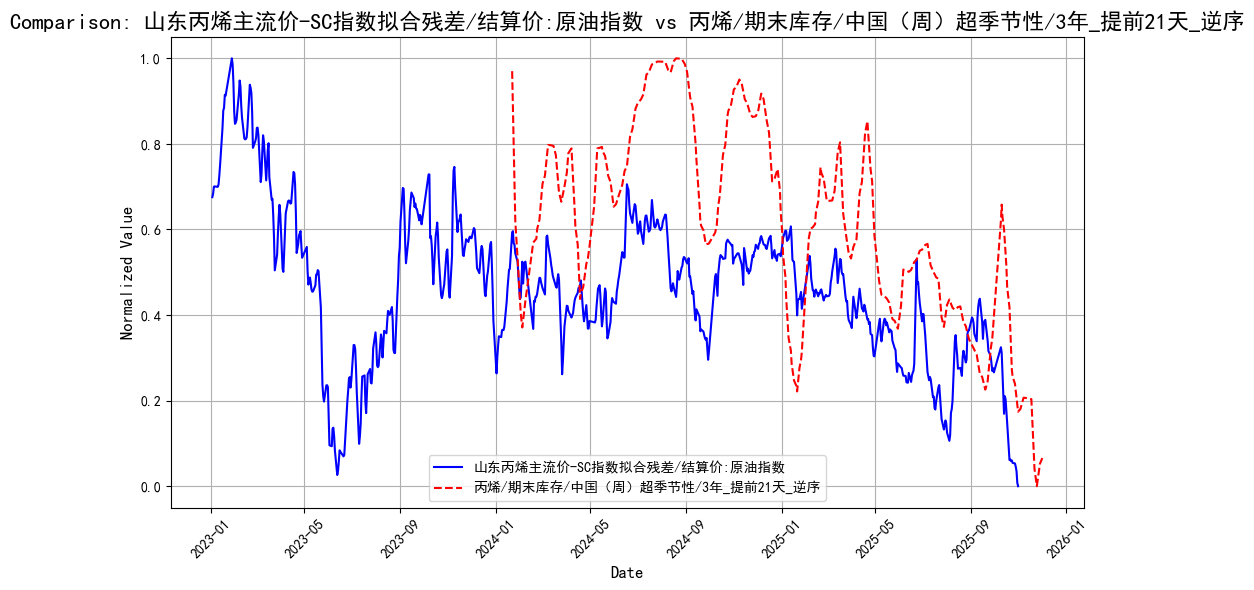

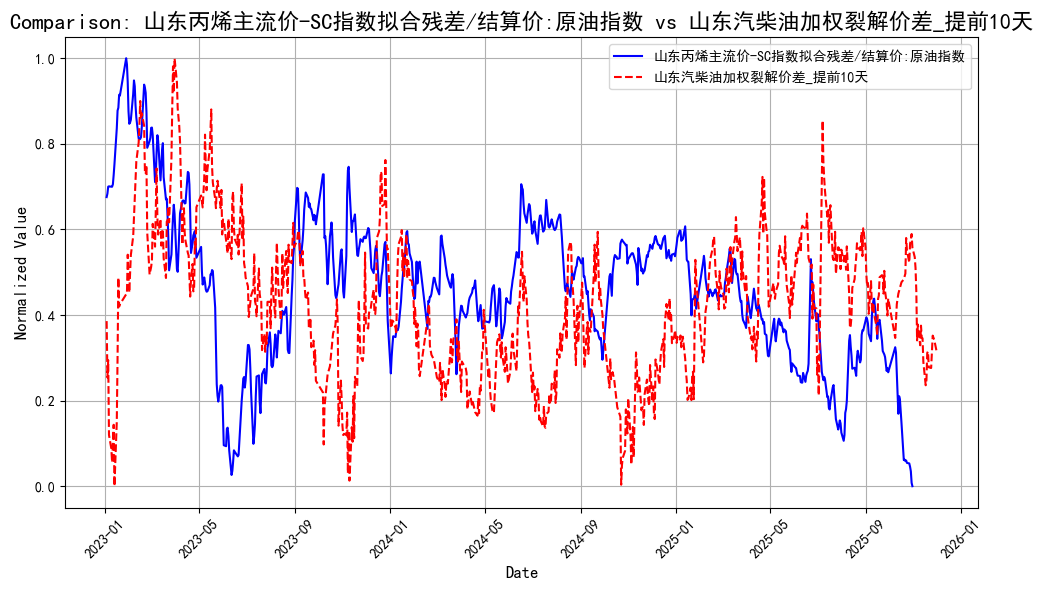

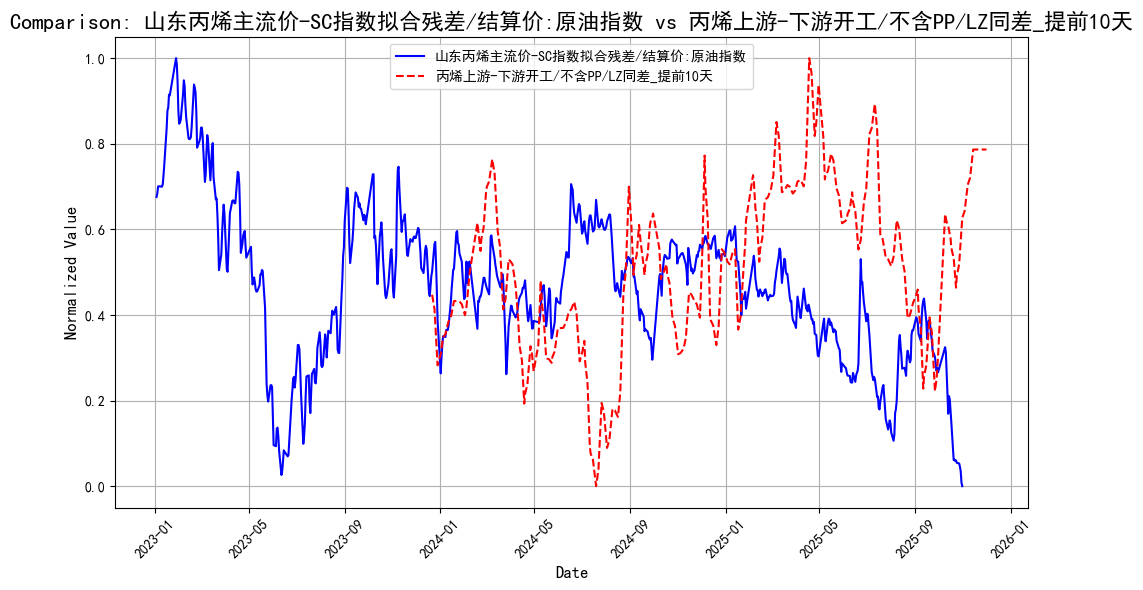

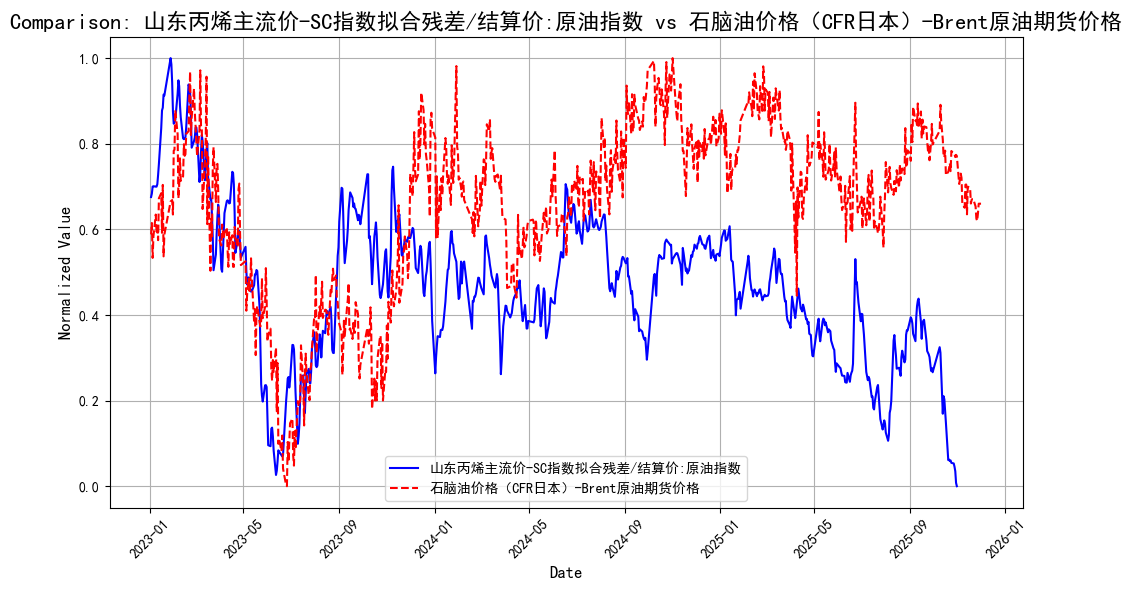

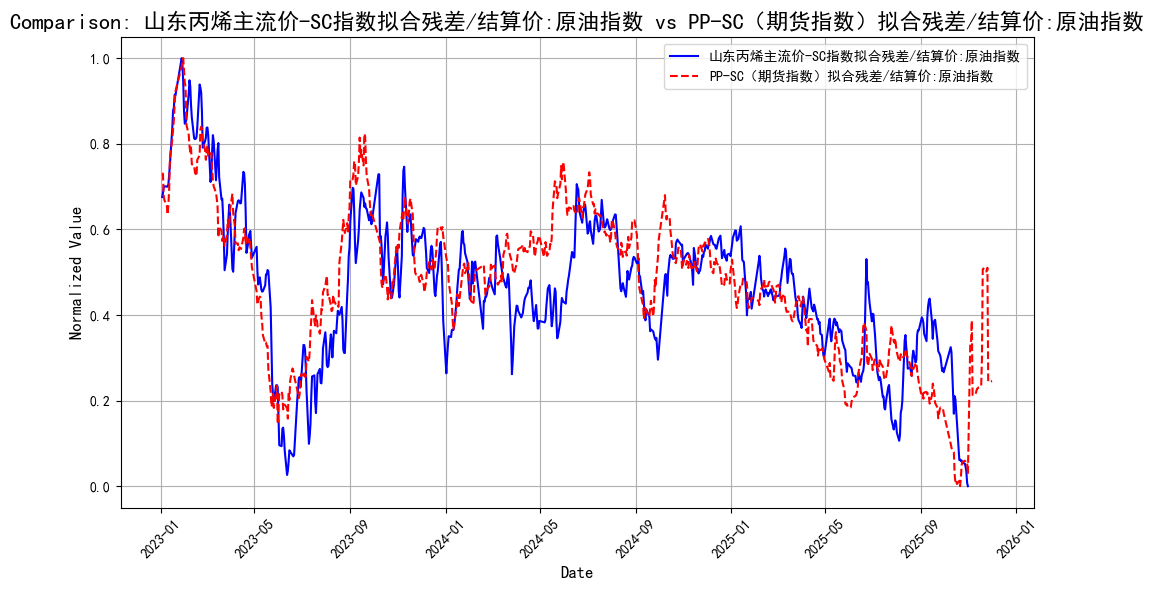

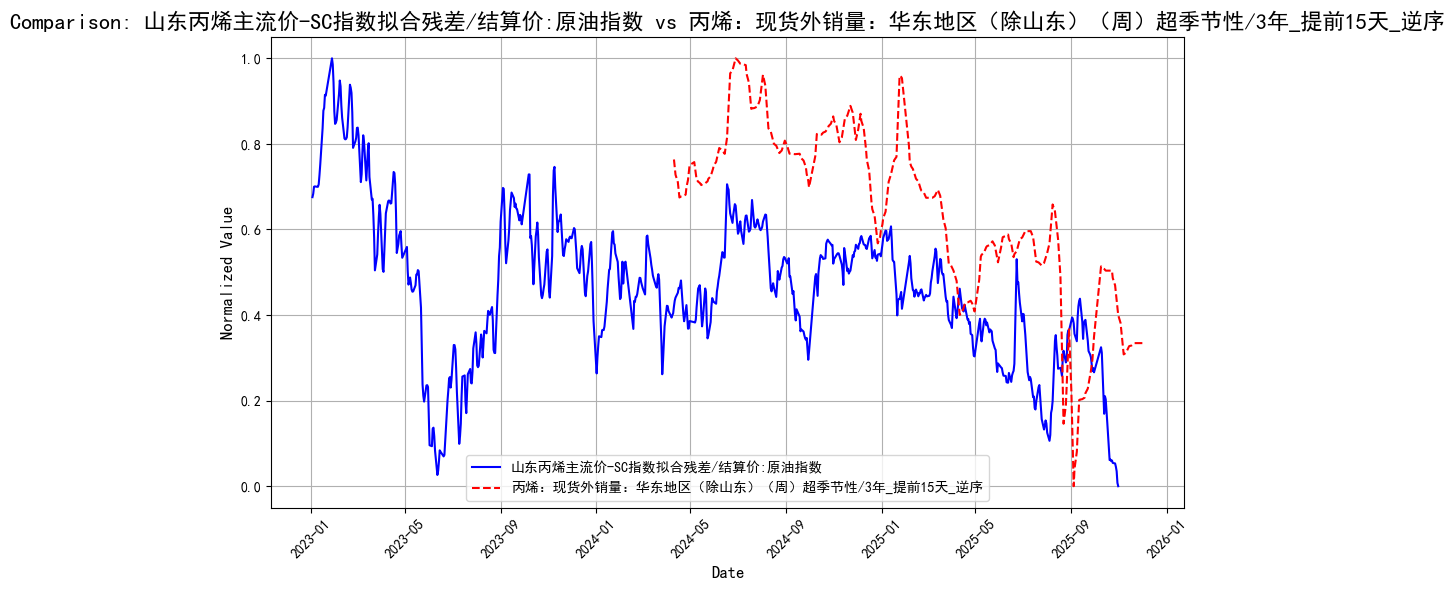

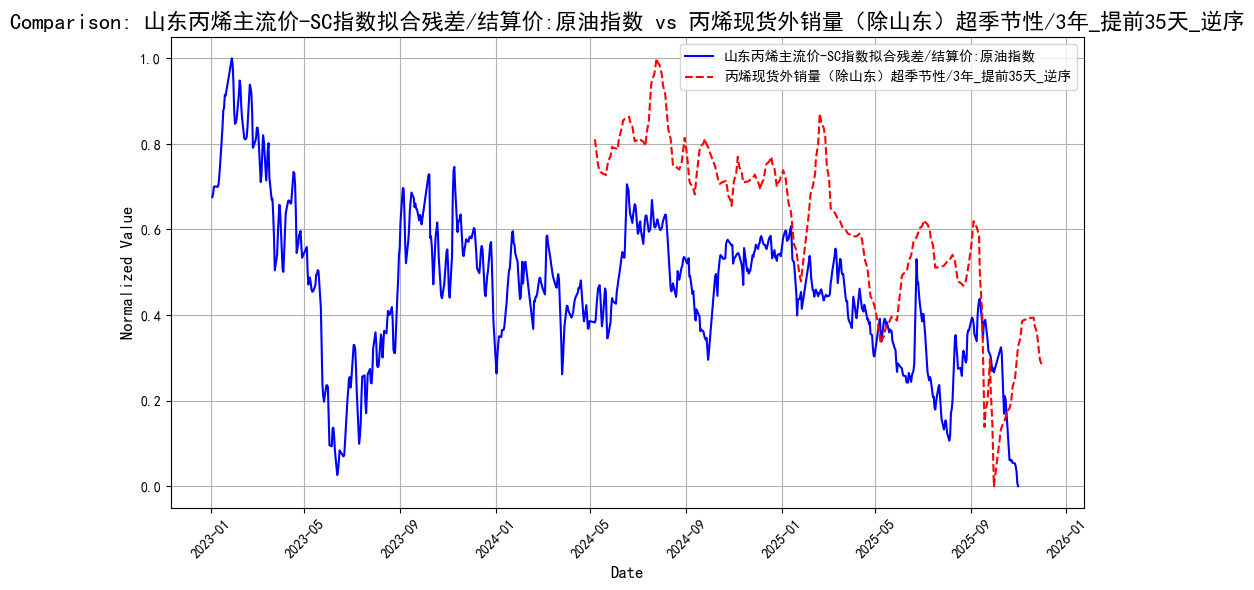

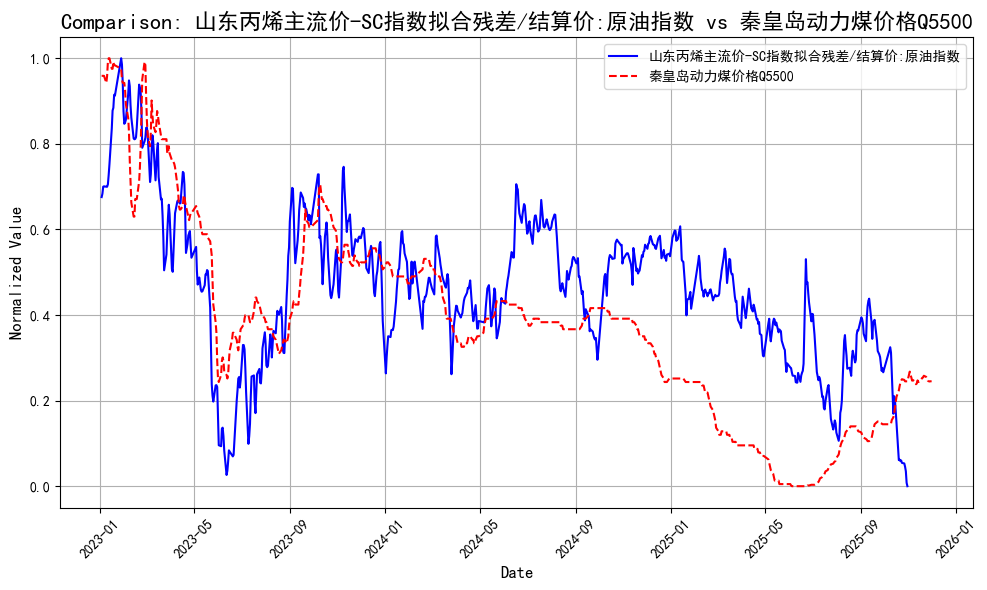

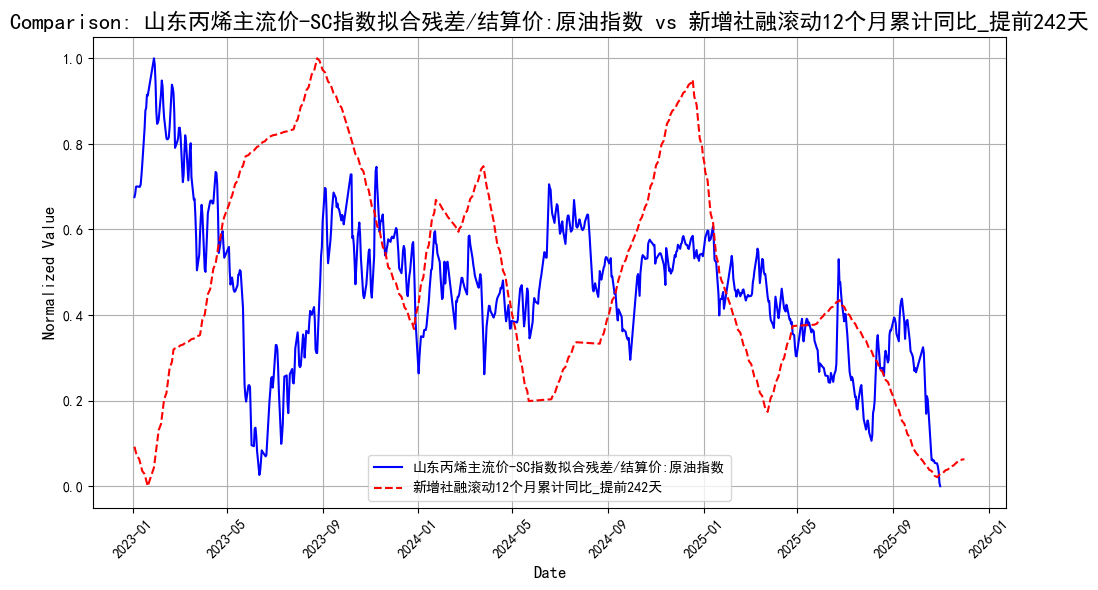

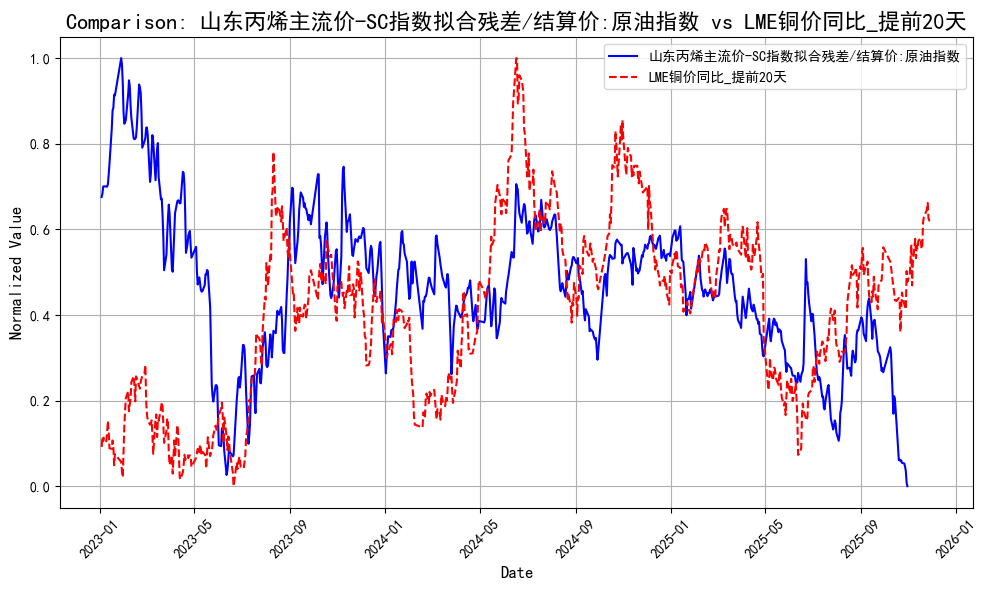

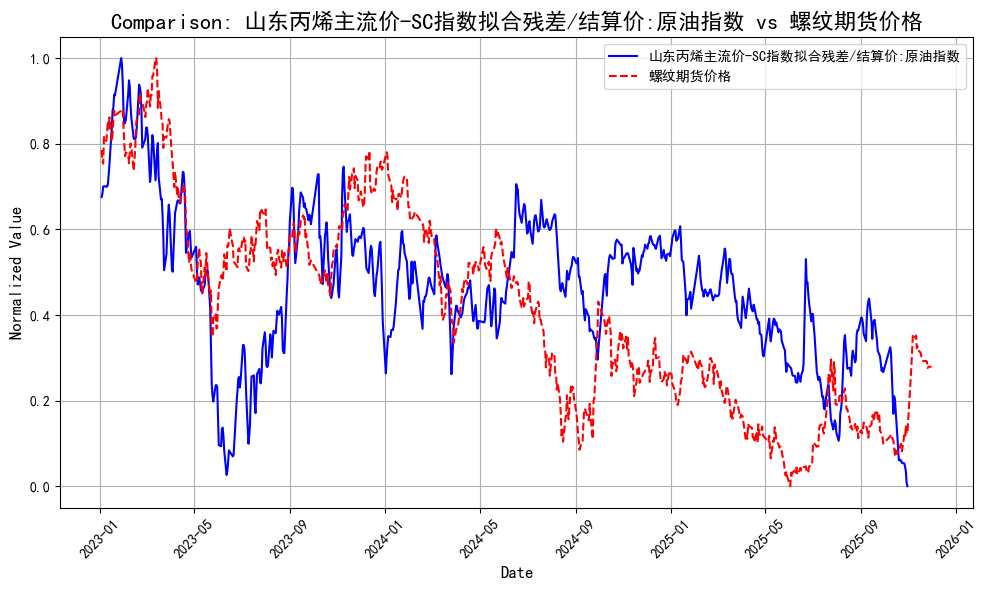

In [16]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='山东丙烯主流价-SC指数拟合残差/结算价:原油指数', 
    compare_cols=[
        '丙烯/期末库存/中国（周）超季节性/3年_提前21天_逆序',
        '山东汽柴油加权裂解价差_提前10天',
        '丙烯上游-下游开工/不含PP/LZ同差_提前10天',
        '石脑油价格（CFR日本）-Brent原油期货价格',
        'PP-SC（期货指数）拟合残差/结算价:原油指数',
        '丙烯：现货外销量：华东地区（除山东）（周）超季节性/3年_提前15天_逆序',
        '丙烯现货外销量（除山东）超季节性/3年_提前35天_逆序',
        '秦皇岛动力煤价格Q5500',
        '新增社融滚动12个月累计同比_提前242天',
        'LME铜价同比_提前20天',
        '螺纹期货价格'
        ]
)

In [17]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 21
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        '丙烯/期末库存/中国（周）超季节性/3年_提前21天_逆序',
        '山东汽柴油加权裂解价差_提前10天',
        '丙烯上游-下游开工/不含PP/LZ同差_提前10天',
        '石脑油价格（CFR日本）-Brent原油期货价格',
        'PP-SC（期货指数）拟合残差/结算价:原油指数',
        '丙烯：现货外销量：华东地区（除山东）（周）超季节性/3年_提前15天_逆序',
        '丙烯现货外销量（除山东）超季节性/3年_提前35天_逆序',
        '秦皇岛动力煤价格Q5500',
        '新增社融滚动12个月累计同比_提前242天',
        'LME铜价同比_提前20天',
        '螺纹期货价格'

]

predict_column = '山东丙烯主流价-SC指数拟合残差/结算价:原油指数'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.06,  # 较小的学习率
    'max_depth':11,  # 控制树的深度防止过拟合
    'min_child_weight': 3,  # 控制过拟合
    'subsample': 0.7627,  # 随机采样防止过拟合
    'colsample_bytree': 0.7046,  # 特征随机采样
    'gamma': 0.3100,  # 控制分裂
    'reg_alpha': 0.3738,  # L1正则化
    'reg_lambda': 1.4775,  # L2正则化
    'eval_metric': 'rmse', # 评估指标：选择“rmse”
    'seed': 42, # 随机种子
   'max_delta_step': 5,
#    'tree_method': 'auto'
}


num_boost_round = 5000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=500 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:594.51126	train-rmse:275.38924


[500]	eval-rmse:456.36562	train-rmse:183.38803


[1000]	eval-rmse:377.36586	train-rmse:113.75531


[1500]	eval-rmse:372.95033	train-rmse:63.48526


[2000]	eval-rmse:372.02552	train-rmse:29.00778


[2500]	eval-rmse:375.81426	train-rmse:9.11938


[3000]	eval-rmse:393.51183	train-rmse:1.81731


[3500]	eval-rmse:397.09016	train-rmse:0.48532


[4000]	eval-rmse:397.58382	train-rmse:0.34324


[4500]	eval-rmse:397.62312	train-rmse:0.32302


[4999]	eval-rmse:397.66828	train-rmse:0.31562


训练集 MSE (DMatrix): 0.1144, 训练集 R² (DMatrix): 1.0
测试集 MSE (DMatrix): 158140.067, 测试集 R² (DMatrix): -3.6877


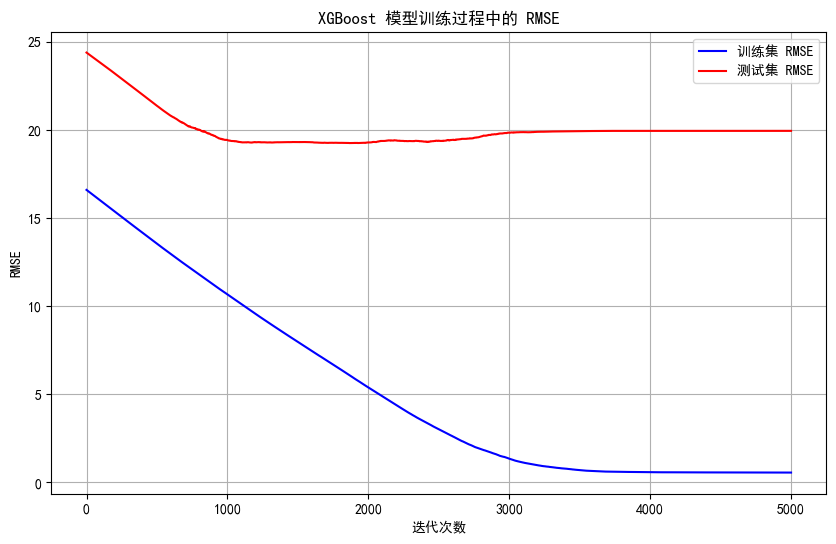

In [18]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=500
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:286.03404


[500]	train-rmse:193.19244


[1000]	train-rmse:122.36745


[1500]	train-rmse:70.64078


[2000]	train-rmse:34.06067


[2500]	train-rmse:11.22465


[3000]	train-rmse:2.19235


[3500]	train-rmse:0.47598


[4000]	train-rmse:0.34737


[4500]	train-rmse:0.33023


[4999]	train-rmse:0.31667


全部数据 MSE: 0.1119, 全部数据 R²: 1.0


Gap between last actual value and first prediction: -246.2430108398437


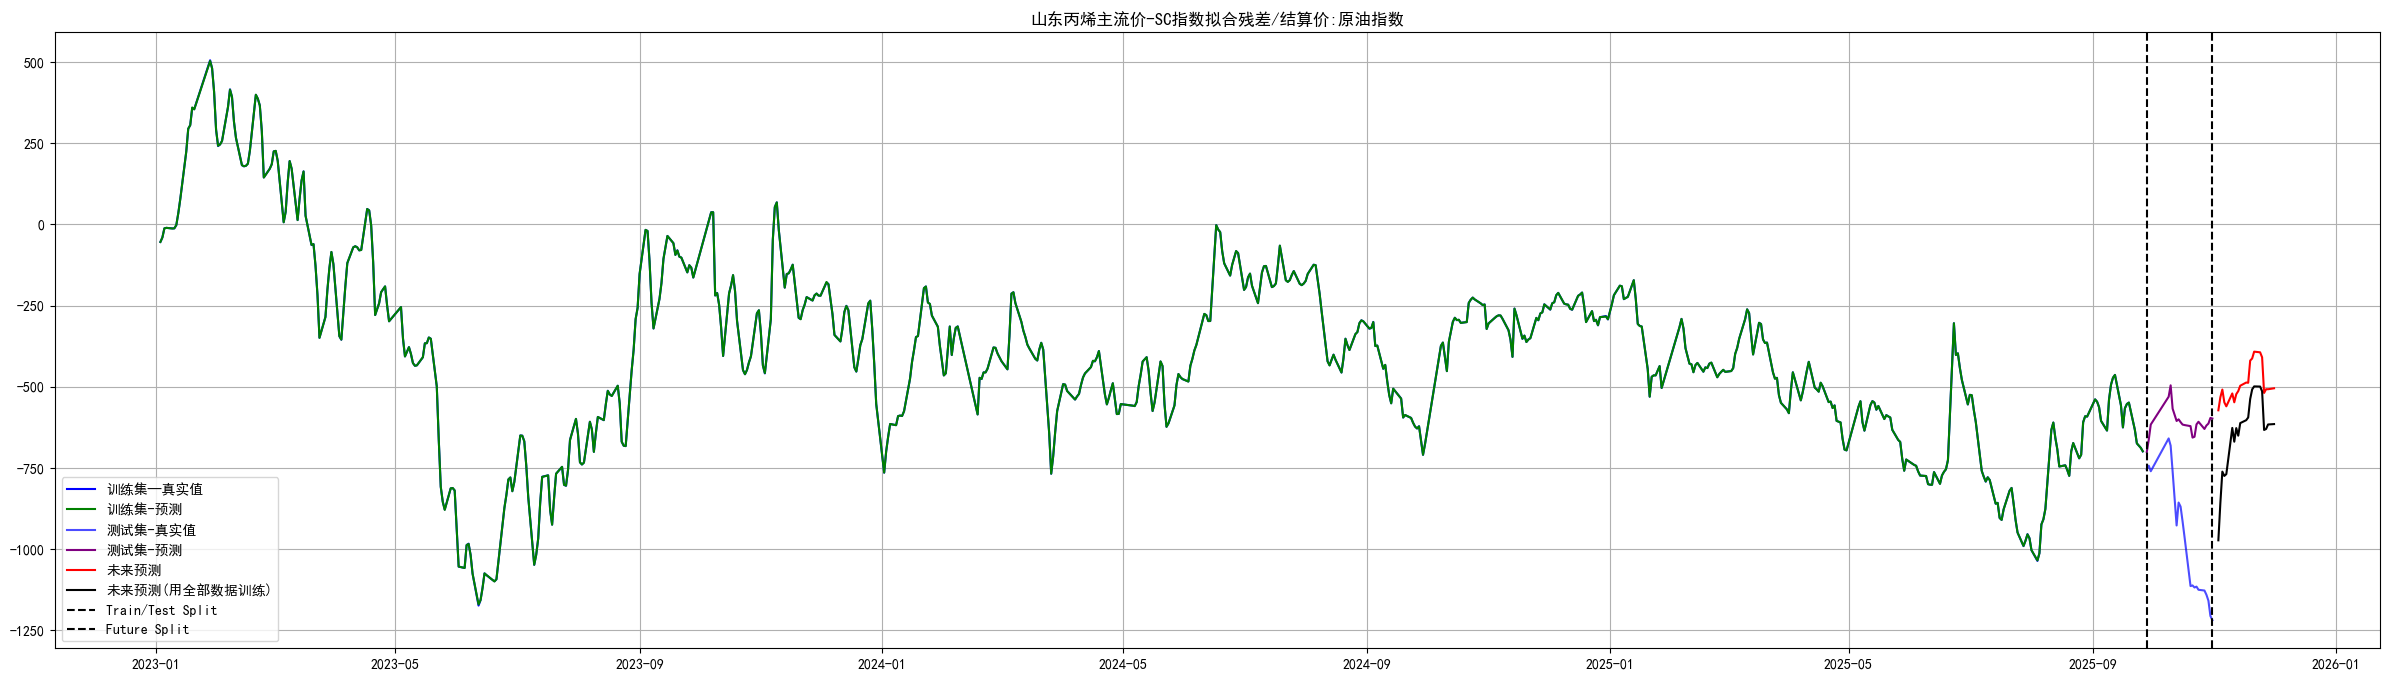

In [20]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
future_data = plot_predictions(y_test, future_data, col=True, label=True)
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('山东丙烯主流价-SC指数拟合残差/结算价:原油指数')
plt.legend()
plt.grid(True)
plt.show()

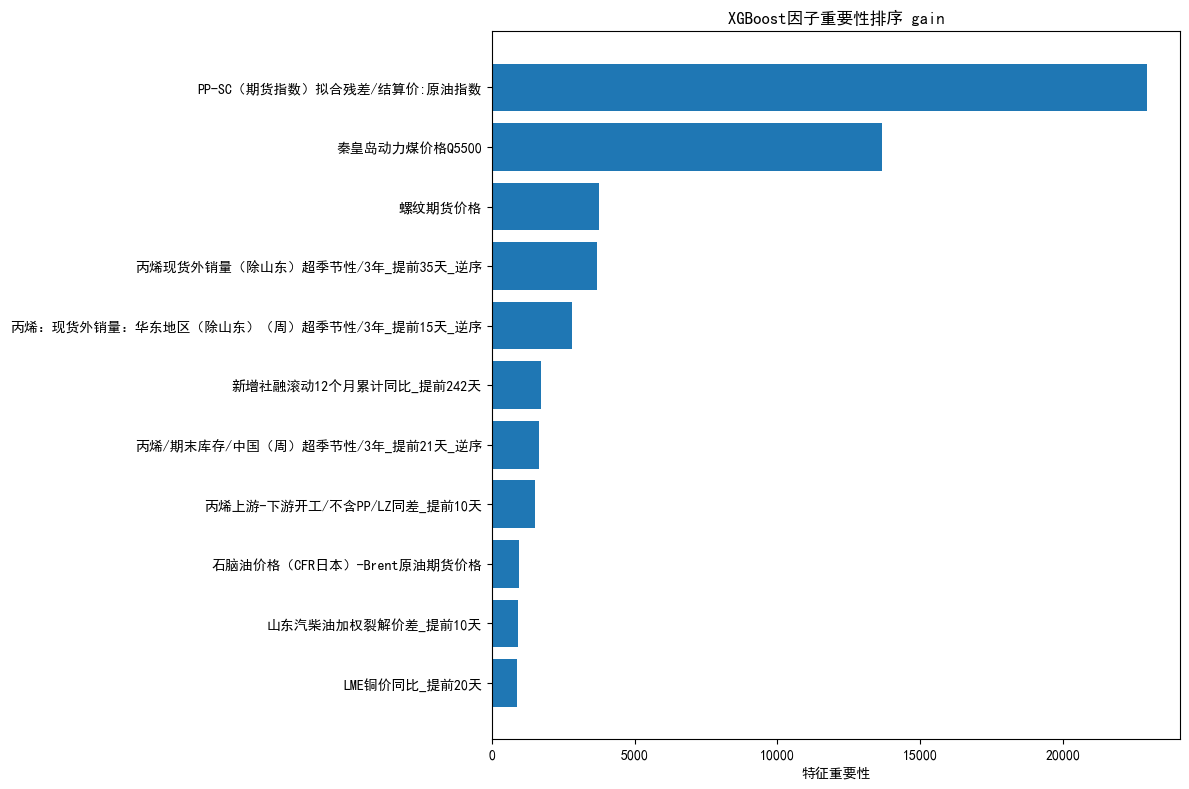

In [21]:

# 创建特征重要性排序的DataFrame
plt.figure(figsize=(12, 8))
importance_type = 'gain'
feature_importance = model_all.get_score(importance_type=importance_type)

importance_df = pd.DataFrame({
    'feature': list(feature_importance.keys()),
    'importance': list(feature_importance.values())
})

# 将特征名称从f0、f1等映射到实际的列名
feature_names = dict(zip([f'f{i}' for i in range(len(X_train.columns))], X_train.columns))
importance_df['feature_name'] = importance_df['feature'].map(feature_names)

# 按重要性降序排序
importance_df_sorted = importance_df.sort_values('importance', ascending=True)

# 绘制水平条形图
plt.barh(range(len(importance_df_sorted)), importance_df_sorted['importance'])
plt.yticks(range(len(importance_df_sorted)), importance_df_sorted['feature_name'], fontsize=10)
plt.xlabel('特征重要性')
plt.title('XGBoost因子重要性排序 gain')
plt.tight_layout()
plt.show()



---

In [22]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})


merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/山东丙烯主流价_SC指数拟合残差_原油指数_合并数据.xlsx', index=False,float_format='%.1f')

merged_df_daily

,Date,真实值,预测值
724,2025/12/01,NaN,-614.986267
723,2025/11/28,NaN,-616.220642
722,2025/11/27,NaN,-630.088745
721,2025/11/26,NaN,-633.051758
720,2025/11/25,NaN,-514.125122
...,...,...,...
4,2023/01/09,-12.4148,NaN
3,2023/01/06,-10.8044,NaN
2,2023/01/05,-12.2135,NaN
1,2023/01/04,-40.2938,NaN


In [23]:
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly = merged_df_monthly.round(2)
merged_df_monthly = merged_df_monthly.dropna(subset=['真实值', '预测值'], how='all')
merged_df_monthly.to_excel('eta/山东丙烯主流价_SC指数_月度数据.xlsx', index=False, float_format='%.1f')
merged_df_monthly.head()

,Date,真实值,预测值
35,2025/12/31,NaN,-614.989990
34,2025/11/30,NaN,-647.900024
33,2025/10/31,-1003.89,-603.099976
32,2025/09/30,-604.07,-591.969971
31,2025/08/31,-760.30,-760.229980


In [24]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "山东丙烯主流价-SC指数拟合残差/结算价:原油指数"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [25]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "山东丙烯主流价-SC指数拟合残差/结算价:原油指数"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件


In [26]:
'''
from Ecel import generate_and_fill_excel
success = generate_and_fill_excel(
    daily_df =  merged_df_daily,
    target_name = 'LME铜价',        # 写入的"预测标的"显示名
    TARGET_COL = '预测值',
    output_path='update.xlsx'
)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")
'''

'\nfrom Ecel import generate_and_fill_excel\nsuccess = generate_and_fill_excel(\n    daily_df =  merged_df_daily,\n    target_name = \'LME铜价\',        # 写入的"预测标的"显示名\n    TARGET_COL = \'预测值\',\n    output_path=\'update.xlsx\'\n)\n\nif success:\n    print("数据已成功更新到Excel文件")\nelse:\n    print("数据更新失败，请检查错误信息")\n'